<a href="https://colab.research.google.com/github/gokul-pv/EVA6_Assignments_Session13/blob/main/EVA6_Session_13_ViT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install vit-pytorch linformer

In [2]:
!pip install kaggle

In [3]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [4]:
! cp kaggle.json ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
 ! kaggle datasets list

401 - Unauthorized


In [7]:
!kaggle competitions download -c dogs-vs-cats-redux-kernels-edition

401 - Unauthorized


In [8]:
# loading Libraries
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt  

In [9]:
# import Linformer
from linformer import Linformer   
import glob   
from PIL import Image
from itertools import chain   
from vit_pytorch.efficient import ViT   
from tqdm.notebook import tqdm   
from __future__ import print_function

In [10]:
# import torch and related libraries 
import torch   
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms   
from torch.optim.lr_scheduler import StepLR   
from torch.utils.data import DataLoader, Dataset

#to unzip the datasets
import zipfile 

In [11]:
#sklearn to split the data
from sklearn.model_selection import train_test_split 

In [12]:
#definining batch size, epocs, learning rate and gamma for training  
batch_size = 64
epochs = 20
lr = 3e-5
gamma = 0.7 #for learning rate scheduler 

In [13]:
#Load data
os.makedirs('data', exist_ok=True)
train_dir = 'data/train'
test_dir = 'data/test'

#Unzipping dataset
with zipfile.ZipFile('train.zip') as train_zip:
    train_zip.extractall('data')
    
with zipfile.ZipFile('test.zip') as test_zip:
    test_zip.extractall('data')

#Creating train and test list 

train_list = glob.glob(os.path.join(train_dir,'*.jpg'))
test_list = glob.glob(os.path.join(test_dir, '*.jpg'))

#printing length of the dataset

print(f"Train Data: {len(train_list)}")
print(f"Test Data: {len(test_list)}")

Train Data: 25000
Test Data: 12500


In [14]:
#Defining labels

labels = [path.split('/')[-1].split('.')[0] for path in train_list]

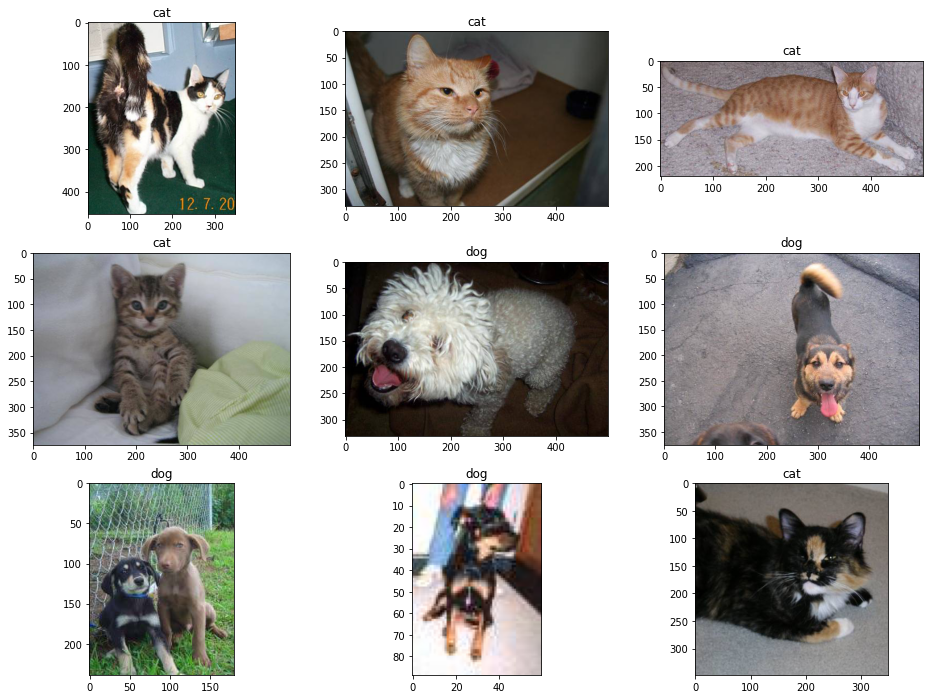

In [15]:
# printing few images 

random_idx = np.random.randint(1, len(train_list), size=9)
fig, axes = plt.subplots(3, 3, figsize=(16, 12))
for idx, ax in enumerate(axes.ravel()):
    img = Image.open(train_list[idx])
    ax.set_title(labels[idx])
    ax.imshow(img)

In [16]:
seed = 40

In [17]:
#Splitting train and validation list

train_list, valid_list = train_test_split(train_list, 
                                          test_size=0.2,
                                          stratify=labels,
                                          random_state=seed)
print(f"Train Data: {len(train_list)}")
print(f"Validation Data: {len(valid_list)}")
print(f"Test Data: {len(test_list)}")

Train Data: 20000
Validation Data: 5000
Test Data: 12500


In [18]:
# Torch transforms

train_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)
val_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)
test_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)

In [19]:
#Loading dataset for training 

class CatsDogsDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform
    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength
    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)
        label = img_path.split("/")[-1].split(".")[0]
        label = 1 if label == "dog" else 0
        return img_transformed, label

In [20]:
#defining train, validation and test dataset
train_data = CatsDogsDataset(train_list, transform=train_transforms)
valid_data = CatsDogsDataset(valid_list, transform=test_transforms)
test_data = CatsDogsDataset(test_list, transform=test_transforms)

In [21]:
#loading dataloader

train_loader = DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True )
valid_loader = DataLoader(dataset = valid_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset = test_data, batch_size=batch_size, shuffle=True)

In [22]:
#Line transformer 

efficient_transformer = Linformer(
    dim=128,
    seq_len=49+1,  # 7x7 patches + 1 cls-token
    depth=12,
    heads=8,
    k=64
)

In [23]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [24]:
#Visual transformer 

model = ViT(
    dim=128,
    image_size=224,
    patch_size=32,
    num_classes=2,
    transformer=efficient_transformer,
    channels=3,
).to(device)

In [25]:
print(model)

ViT(
  (to_patch_embedding): Sequential(
    (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=32, p2=32)
    (1): Linear(in_features=3072, out_features=128, bias=True)
  )
  (transformer): Linformer(
    (net): SequentialSequence(
      (layers): ModuleList(
        (0): ModuleList(
          (0): PreNorm(
            (fn): LinformerSelfAttention(
              (to_q): Linear(in_features=128, out_features=128, bias=False)
              (to_k): Linear(in_features=128, out_features=128, bias=False)
              (to_v): Linear(in_features=128, out_features=128, bias=False)
              (dropout): Dropout(p=0.0, inplace=False)
              (to_out): Linear(in_features=128, out_features=128, bias=True)
            )
            (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          )
          (1): PreNorm(
            (fn): FeedForward(
              (w1): Linear(in_features=128, out_features=512, bias=True)
              (act): GELU()
              (dropout)

In [26]:
# loss function
criterion = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)

# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

In [27]:
#start training

for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0
    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)
        output = model(data)
        loss = criterion(output, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)
    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(device)
            val_output = model(data)
            val_loss = criterion(val_output, label)
            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)
    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 1 - loss : 0.6953 - acc: 0.5021 - val_loss : 0.6985 - val_acc: 0.4972



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.6914 - acc: 0.5224 - val_loss : 0.6853 - val_acc: 0.5508



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.6845 - acc: 0.5549 - val_loss : 0.6838 - val_acc: 0.5514



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.6744 - acc: 0.5795 - val_loss : 0.6741 - val_acc: 0.5783



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 5 - loss : 0.6705 - acc: 0.5837 - val_loss : 0.6676 - val_acc: 0.5825



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 6 - loss : 0.6619 - acc: 0.5941 - val_loss : 0.6615 - val_acc: 0.5890



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 7 - loss : 0.6509 - acc: 0.6040 - val_loss : 0.6558 - val_acc: 0.5967



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 8 - loss : 0.6419 - acc: 0.6149 - val_loss : 0.6410 - val_acc: 0.6278



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 9 - loss : 0.6379 - acc: 0.6277 - val_loss : 0.6409 - val_acc: 0.6201



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 10 - loss : 0.6297 - acc: 0.6361 - val_loss : 0.6267 - val_acc: 0.6470



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 11 - loss : 0.6198 - acc: 0.6490 - val_loss : 0.6132 - val_acc: 0.6618



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 12 - loss : 0.6158 - acc: 0.6505 - val_loss : 0.6210 - val_acc: 0.6485



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 13 - loss : 0.6125 - acc: 0.6526 - val_loss : 0.6193 - val_acc: 0.6485



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 14 - loss : 0.6048 - acc: 0.6655 - val_loss : 0.6062 - val_acc: 0.6644



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 15 - loss : 0.5977 - acc: 0.6712 - val_loss : 0.6208 - val_acc: 0.6517



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 16 - loss : 0.6001 - acc: 0.6683 - val_loss : 0.6070 - val_acc: 0.6640



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 17 - loss : 0.5944 - acc: 0.6729 - val_loss : 0.6016 - val_acc: 0.6671



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 18 - loss : 0.5928 - acc: 0.6750 - val_loss : 0.5968 - val_acc: 0.6675



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 19 - loss : 0.5913 - acc: 0.6778 - val_loss : 0.6059 - val_acc: 0.6650



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 20 - loss : 0.5871 - acc: 0.6786 - val_loss : 0.5924 - val_acc: 0.6766

